<center>
    <h1>Bayesian Portfolio Optimization</h1>

    <h2></h2>
    <img src="./images/markowitz_bullet.png" alt="Portfolio Optimization" style="width: 400px;"/>
    
    <h4>Max Margenot</h4>
    <h4>Lead - Data Science at Quantopian</h4>
</center>



*This presentation is for informational purposes only and does not constitute an offer to sell, a solicitation to buy, or a recommendation for any security; nor does it constitute an offer to provide investment advisory or other services by Quantopian, Inc. ("Quantopian"). Nothing contained herein constitutes investment advice or offers any opinion with respect to the suitability of any security, and any views expressed herein should not be taken as advice to buy, sell, or hold any security or as an endorsement of any security or company. In preparing the information contained herein, Quantopian, Inc. has not taken into account the investment needs, objectives, and financial circumstances of any particular investor. Any views expressed and data illustrated herein were prepared based upon information, believed to be reliable, available to Quantopian, Inc. at the time of publication. Quantopian makes no guarantees as to their accuracy or completeness. All information is subject to change and may quickly become unreliable for various reasons, including changes in market conditions or economic circumstances.*

# Background

* Me

# The Problem

In finance, a base unit of work is the creation of some sort of portfolio

This can be simple or complex

# Risk

What is risk?

Something you don't want?

Something you do want?

# Modern Portfolio Theory

A framework for finding portfolios that maximize expected return while minimizing risk.

Portfolio Diversification
* Constant advice.
* Important at all levels of investment.

# A Simple Example

In [1]:
import numpy as np

In [7]:
N = 5

returns = np.zeros((N, 100))
assets = np.zeros((N, 100))

for i in range(0, N):
    R_i = np.random.normal(1.01, 0.03, 100)
    returns[i] = R_i
    assets[i] = np.cumprod(R_i)

R_P = np.mean(returns, axis=0)
P = np.mean(assets, axis=0)

In [8]:
mu = np.mean(returns, axis=1) - 1
sigma = np.std(returns, axis=1)

weights = np.array([1./N for asset in mu])

In [9]:
print('Asset Returns are: ', mu)
print('Asset Volatilities are: ', sigma)

Asset Returns are:  [0.01128308 0.00909864 0.01244061 0.00890112 0.00887826]
Asset Volatilities are:  [0.02803311 0.03293182 0.03100948 0.0293683  0.02973995]


In [10]:
print('Portfolio Return is: ', mu.dot(weights))

Portfolio Return is:  0.0101203426774652


In [11]:
print('Portfolio Volatility is: ', np.sqrt((weights**2).dot(sigma**2)))

Portfolio Volatility is:  0.01353352766800903


# Generalization

$$ P = \sum_{i=1}^N \omega_i S_i $$

$$ E[\mu_P] = \sum_{i=1}^N \omega_i \mu_i $$

$$ VAR[P] = \sigma_p^2 = \sum_{i=1}^N \omega_i^2 \sigma_i^2 + \sum_{i=1}^N \sum_{j=1, j\neq i}^N \omega_i\omega_j \sigma_i\sigma_j \rho_{ij}$$

# Portfolio Optimization

Given a potentially massive universe of securities available to trade, what is the best way to combine the assets you want?

Is there a "correct" way to determine $\{\omega_i\}_{i=1}^N$?

We can express this as a conventional optimization problem, with objective and constraints.

Expressing this selection of weights as an optimization problem allows us to easily find the right weights given an objective function (i.e. what we mean by optimal) as well as constraints (leverage or exposure to certain risk factors).

# Markowitz Portfolio Optimization

Given a set of assets, $\{S_i\}_{i=1}^N$, with expected returns $\{R_i\}_{i=1}^N$ and covariance matrix $\Sigma$,

\begin{equation*}
\begin{aligned}
& \underset{\omega} {\text{minimize}}
& & \omega^\top\Sigma\omega - R^\top\omega \\
& \text{subject to}
& & \sum_{i=1}^N \omega_i = 1
\end{aligned}
\end{equation*}



* We're still riffing on this.

# Why is this Hard?

* Traditional covariance is unstable.

* Too many observations are necessary to make it stable.

* Correlations change over time.

* There's a Wikipedia article about this, so it must be: https://en.wikipedia.org/wiki/Estimation_of_covariance_matrices.

<center>
<img src="./images/conventional_variance.png" alt="Sample variances" style="width: 600px;"/>
</center>

<center>
<img src="./images/traditional_correlation.png" alt="Sample correlations" style="width: 600px;"/>
</center>

# But Let's Take a Step Back

Uncertainty gives us strength.

In finance, this gives us even more confidence.

# Bayesian Statistics

Bayesian statistics is a statistical framework for quantifying uncertainty in the form of probability distributions.

$$ P(\theta\ |\ \mathbf{X}) = \frac{P(\mathbf{X}\ |\ \theta)\  P(\theta)}{P(\mathbf{X})} \propto P(\mathbf{X}\ |\ \theta)\  P(\theta) $$

* $P(\theta\ |\ \mathbf{X})$ is our posterior distribution.
* $P(\mathbf{X}\ |\ \theta)$ is the likelihood of the model.
* $P(\theta)$ is our prior distribution.

# Prior Work

<center>
<img src="./images/pymc3_stoch_vol_example.png" alt="Stochastic volatility model from PyMC3 docs" style="width: 600px;"/>
</center>

# Probabilistic Programming
Probabilistic programming is a tool that helps us express this problem using code. 

We set our priors and our likelihood and the sampler does the heavy lifting.

In [ ]:
with pm.Model() as model:
    step_size = pm.Exponential('sigma', 50.)
    s = GaussianRandomWalk('s', sd=step_size,
                           shape=len(returns))

    nu = pm.Exponential('nu', .1)

    r = pm.StudentT('r', nu=nu,
                    lam=pm.math.exp(-2*s),
                    observed=returns)

In [ ]:
def build_basic_rw_model(observations, subsample_rate=30):
    total_time, n_secs = observations.shape
    with pm.Model() as bayesian_cov:
        log_var = pm.GaussianRandomWalk(
            "log_var", 
            mu=0,
            sd=.1,
            shape=(total_time//subsample_rate, n_secs),
        )
        var = tt.exp(log_var)
        
        lower_chol = pm.GaussianRandomWalk(
            "lower_chol",
            mu=0,
            sd=.1,
            shape=(total_time//subsample_rate, n_secs*(n_secs-1)//2)
        )
        cholesky = tt.as_tensor(
            [expand_diag_lower(n_secs, var[t,:], lower_chol[t,:])
                for t in range(total_time//subsample_rate)])
        
        covariance = pm.Deterministic(
            'covariance',
            tt.as_tensor([cholesky[t].dot(cholesky[t].T)
                          for t in range(total_time//subsample_rate)])
        )

        reshaped_returns = observations.values[
            :(subsample_rate*(total_time//subsample_rate))
        ].reshape(total_time//subsample_rate, subsample_rate, n_secs)
        time_segments, _, _ = reshaped_returns.shape
        
        for t in range(time_segments):
            pm.MvNormal(
                'likelihood_{0}'.format(t),
                mu=np.zeros(n_secs),
                chol=cholesky[t,:,:],
                observed=reshaped_returns[t]
            )
    return bayesian_cov

In [ ]:
with model:
    trace = pm.sample(1000, tune=1000, njobs=2)

# Probabilistic Programming

With this in mind, we set the following priors for our returns and covariance matrix:

\begin{eqnarray*}
    R &\sim& MvNormal(0, \Sigma) \\
    L &\sim& \exp[GaussianRandomWalk(0, 0.1)]\\
    \Sigma &=& LL^\top
\end{eqnarray*}

where $\Sigma = LL^\top$ is the Cholesky decomposition of $\Sigma$.

In [3]:
symbols = [u'EEM', u'EWG', u'EWJ', u'EFA', u'EWQ', 
           u'EWU', u'XLB', u'XLE', u'XLF', u'XLK',
           u'XLU', u'EPP', u'FXI', u'VGK', u'VPL',
           u'SPY', u'DIA']

rets = get_pricing(symbols,
                   start_date='2014-01-01',
                   end_date='2016-07-01',
                   fields='close_price')

/mnt/efs/home/mmargenot/miniconda2/envs/mmargenot/lib/python3.5/site-packages/ipykernel_launcher.py:9: DeprecationWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  if __name__ == '__main__':


# Trading Universe

17 ETFs, examined in a previous post from the Quantopian Forums.

In [4]:
rets.head()

,EEM,EWG,EWJ,EFA,EWQ,EWU,XLB,XLE,XLF,XLK,XLU,EPP,FXI,VGK,VPL,SPY,DIA
2014-01-03 00:00:00+00:00,-0.002594,-0.003562,0.005020,0.000608,-0.003961,0.000000,-0.002086,-0.003216,0.005975,-0.005208,-0.002946,0.002374,-0.012402,0.000172,0.003227,-0.000874,0.001277
2014-01-06 00:00:00+00:00,-0.009590,0.004581,-0.002498,-0.000755,-0.001443,-0.002926,-0.005673,0.000920,0.000910,-0.001576,0.000790,-0.004521,-0.017197,0.000536,-0.003726,-0.002134,-0.002551
2014-01-07 00:00:00+00:00,0.004271,0.004214,0.004144,0.005308,0.007263,0.004652,-0.001663,0.007930,0.000479,0.008818,0.009384,0.001730,0.000295,0.006769,0.003334,0.005758,0.006220
2014-01-08 00:00:00+00:00,-0.002245,-0.002924,0.002494,-0.000147,-0.002171,-0.001709,0.005623,-0.006956,0.004113,0.000295,-0.005561,-0.002807,0.011092,-0.000703,0.000985,0.000493,-0.003396
2014-01-09 00:00:00+00:00,-0.005798,-0.002104,-0.004117,-0.000768,-0.002875,-0.001436,-0.003497,-0.003098,0.003192,-0.006495,0.006116,-0.001083,-0.017826,0.000703,-0.003794,0.000435,-0.000973


In [5]:
def expand_diag_lower(n, diag, lower):
    # helper function
    out = tt.zeros((n, n), dtype=theano.config.floatX)
    idxs = np.tril_indices(n, k=-1)
    out = tt.set_subtensor(out[idxs], lower)
    idxs = np.diag_indices(n)
    return tt.set_subtensor(out[idxs], diag)

In [6]:
def build_basic_rw_model(observations, subsample_rate=30):
    total_time, n_secs = observations.shape
    with pm.Model() as bayesian_cov:
        # make the variance
        log_var = pm.GaussianRandomWalk(
            "log_var", 
            mu=0,
            sd=.1,
            shape=(total_time//subsample_rate, n_secs),
        )
        var = tt.exp(log_var)
        
        # make the cholesky matrix
        lower_chol = pm.GaussianRandomWalk(
            "lower_chol",
            mu=0,
            sd=.1,
            shape=(total_time//subsample_rate, n_secs*(n_secs-1)//2)
        )
        cholesky = tt.as_tensor(
            [expand_diag_lower(n_secs, var[t,:], lower_chol[t,:])
                for t in range(total_time//subsample_rate)])
        
        # expand the cholesky into the covariance
        covariance = pm.Deterministic(
            'covariance',
            tt.as_tensor([cholesky[t].dot(cholesky[t].T)
                          for t in range(total_time//subsample_rate)])
        )

        # reshape the observations
        reshaped_returns = observations.values[
            :(subsample_rate*(total_time//subsample_rate))
        ].reshape(total_time//subsample_rate, subsample_rate, n_secs)
        time_segments, _, _ = reshaped_returns.shape
        
        # make the likelihood
        for t in range(time_segments):
            pm.MvNormal(
                'likelihood_{0}'.format(t),
                mu=np.zeros(n_secs),
                chol=cholesky[t,:,:],
                observed=reshaped_returns[t]
            )
    return bayesian_cov

In [7]:
subsample_rate = 30
basic_model = build_basic_rw_model(rets, subsample_rate=subsample_rate)

### Cry Havoc

Despite the complexity of this model, sampling in PyMC3 handles it well:

In [8]:
with basic_model:
    basic_trace = pm.sample(1000, tune=1000, njobs=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lower_chol, log_var]
Sampling 2 chains: 100%|██████████| 4000/4000 [1:01:04<00:00,  1.34s/draws]
The number of effective samples is smaller than 25% for some parameters.


# Trace

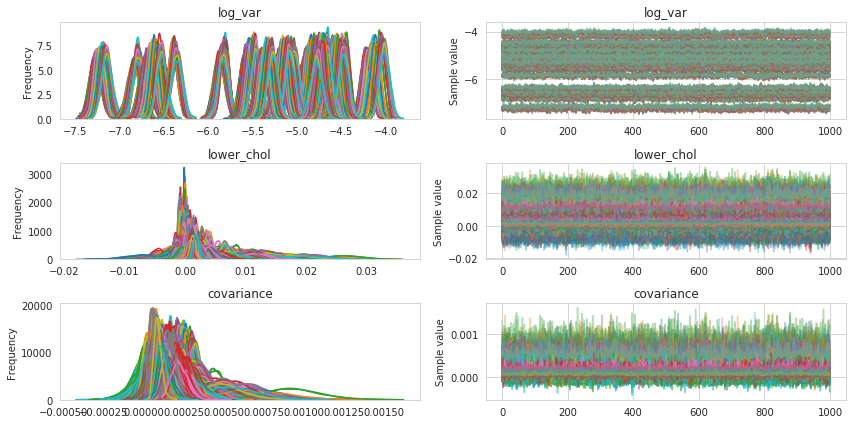

In [9]:
pm.traceplot(basic_trace);

# Diagnostics

In [10]:
gr_stats = pm.diagnostics.gelman_rubin(basic_trace)

In [11]:
print("Average Gelman-Rubin Statistics:")
for variable, stats in gr_stats.items():
    print("{0}: {1}".format(variable, np.mean(stats)))

Average Gelman-Rubin Statistics:
lower_chol: 1.0000496175923863
log_var: 1.0014056609265363
covariance: 1.0003739493094546


Numbers close to 1 indiciate good convergence between chains.

## Posteriors

<center>
<img src="./images/bayesian_variance.png" alt="Bayesian variance estimates" style="width: 600px;"/>
</center>

## Posteriors

<center>
<img src="./images/bayesian_correlation.png" alt="Bayesian correlation estimates" style="width: 600px;"/>
</center>

What is quite striking from the correlations plot is how wide our uncertainty is which matches our general experience of correlations being very unstable. But here, rather than assuming a single value the model can communicate that its very uncertain.

To drive this point home further let's compare these results with what we would get from a classic rolling-window approach.

In [23]:
import cvxpy
from tqdm import tqdm, trange

In [24]:
# Mean-Variance Optimization
def get_markowitz_weights(mu, Sigma, max_position=0.50, max_leverage=1.0, short=True):
    """ Obtain the Markowitz optimization weights for a given set of mean returns
    and covariance matrix.
    
    Parameters
    ----------
    mu : ndarray
        input array of returns
    Sigma : ndarray
        covariance matrix
    max_position : float, optional
        the maximum weight allowed for a position in any individual security
    max_leverage : float, >0, optional
        the maximum leverage allowed in the portfolio
    short : bool, optional
        allow negative positions
        
    Returns
    -------
    w : ndarray
        optimal weights for set of inputs"""
    w = cvxpy.Variable(len(Sigma))
    L = cvxpy.Parameter()
    L.value = max_leverage
    try:
        ret = mu.T*w
    except ValueError:
        ret = mu*w
    
    risk = cvxpy.quad_form(w, Sigma)
    
    objective = cvxpy.Maximize(ret - risk)
    constraints = [
        cvxpy.abs(w) <= max_position,
        cvxpy.norm(w, 1) <= L, # Make it so we don't have to invest everything
    ]
    
    if not short:
        constraints.append(w >= 0) # Force all positive weights
    
    prob = cvxpy.Problem(
        objective,
        constraints
    )
    
    result = prob.solve()
    
    return w.value

In [25]:
def get_posterior_markowitz_weights(mu, Sigma, max_position=1.0, max_leverage=1.0, short=True):
    """ Obtain the Markowitz optimization weights for a posterior distribution of
    covariance matrices, given a set of mean returns and a posterior distribtuion.
    
    Parameters
    ----------
    mu : ndarray
        input array of returns
    Sigma : ndarray
        covariance matrix distribution, Samples x Time x N x N
    max_position : float, optional
        the maximum weight allowed for a position in any individual security
    max_leverage : float, >0, optional
        the maximum leverage allowed in the portfolio
    short : bool, optional
        allow negative positions
        
    Returns
    -------
    w : ndarray
        optimal weights for set of inputs"""
    
    samples = len(Sigma)
    total_time = len(mu)
    total_time_blocks = Sigma.shape[1]
    subsample_rate = int(total_time//(total_time/float(Sigma.shape[1])))
    num_secs = Sigma.shape[3]
    
    try:
        mu_vals = mu.values
    except AttributeError:
        mu_vals = mu
    
    posterior_weights = np.zeros((samples, total_time_blocks, num_secs))
    for t in trange(1, total_time_blocks+1):
        for n in range(samples):
            current_returns = np.mean(mu_vals[((t-1)*subsample_rate):(t*subsample_rate)], axis=0)
            current_cov = Sigma[n][t-1, :, :]
            
            posterior_weights[n][t-1] = get_markowitz_weights(
                current_returns,
                current_cov,
                max_position=max_position,
                max_leverage=max_leverage,
                short=short
            ).T
    return posterior_weights

In [26]:
max_position = 1.0
max_leverage = 1.0

posterior_markowitz_weights = get_posterior_markowitz_weights(
    rets,
    posterior_covariance,
    max_position=max_position,
    max_leverage=max_leverage,
    short=True
)

100%|██████████| 20/20 [13:56<00:00, 41.81s/it]


In [27]:
min_var_returns = np.ones(rets.shape)

In [28]:
posterior_min_var_weights = get_posterior_markowitz_weights(
    min_var_returns,
    posterior_covariance,
    max_position=max_position,
    max_leverage=max_leverage,
    short=True
)

100%|██████████| 20/20 [13:42<00:00, 41.13s/it]


# Stochastic Optimization

We have a distribution of covariances instead of single values.

So we have a distribution of possible weights.

# Markowitz Weights

<center>
<img src="./images/bayesian_markowitz_weights.png" alt="Bayesian Markowitz weights" style="width: 600px;"/>
</center>

# Min-Variance Portfolio

Variant of Markowitz that disregards the returns, finding the portolio with minimum variance.

Generally more stable.

# Traditional Min-Variance

<center>
<img src="./images/traditional_min_variance_weights.png" alt="Traditional min-variance weights" style="width: 600px;"/>
</center>

# Bayesian Min-Variance

<center>
<img src="./images/bayesian_inverse_variance_weights.png" alt="Bayesian min-variance weights" style="width: 600px;"/>
</center>

As we can see, the resulting weights now have uncertainty associated to them. However, as is the tendency with Markowitz mean-variance, it is still often very concentrated on individual stocks.

Let's see if minimum-variance (taking on correlations but not mean returns into account) does any better.

# Evaluation

Performance

* Sharpe Ratio - $ \frac{E[R_p] - R_f}{\sigma_p} $

Stability (Turnover)

* Mean %-change in weights

## Performance

As far as the actual performance of this optimization is routined, we care about two main things, turnover and Sharpe ratio. In order to actually use the Bayesian weights, we use the mean of the posterior distribution for a given asset's weight as the weight in the portfolio.

### Turnover
The first is the turnover of the weights from period to period. Because we expect the Bayesian covariance estimate to be a more stable reflection of the state of the relationship between all the assets in the portfolio, we hope that the turnover from period to period with the Bayesian estimate will be less than the turnover with more traditional methods. 

In [41]:
mean_posterior_min_var_weights = posterior_min_var_weights.mean(axis=0)

In [42]:
# weight is already a proportion of the overall portfolio so we can just sum
def calc_turnover(weights_over_time):
    total_time = weights_over_time.shape[0]
    turnover = np.zeros(weights_over_time.shape[0] - 1)
    for t in trange(1, total_time):
        # Total turnover at each period is the sum of whatever metric
        turnover[t-1] = np.mean(
            (weights_over_time[t, :]-weights_over_time[t-1, :]) / 
                weights_over_time[t-1, :]
        )
    return turnover

In [43]:
posterior_turnover = calc_turnover(mean_posterior_min_var_weights)
trad_turnover = calc_turnover(trad_naive_min_var_weights)

100%|██████████| 19/19 [00:00<00:00, 55534.34it/s]


# Performance

<center>
<img src="./images/bayesan_vs_trad_sharpe_ratio.png" alt="Sharpe ratio comparison between two portfolios" style="width: 600px;"/>
</center>

# Performance

In [54]:
print("Traditional Sharpe: {0}".format(trad_sharpe))
print("Bayes Sharpe: {0}".format(bayes_sharpe))

Traditional Sharpe: 0.009164938290031363
Bayes Sharpe: 0.011614755741102979


# Turnover

<center>
<img src="./images/bayesian_vs_trad_turnover.png" alt="Turnover comparison between two portfolios" style="width: 600px;"/>
</center>

# Turnover

In [72]:
print('Mean Turnover:')
print('Traditional Minimum Variance Weights: ', np.mean(trad_turnover))
print('Bayesian Minimum Variance Weights: ', np.mean(posterior_turnover))

Mean Turnover:
Traditional Minimum Variance Weights:  0.013758003734391335
Bayesian Minimum Variance Weights:  0.009292716474402404


# Possible Improvements

The model still leaves a few things to be desired. 

* Placing a random walk distribution on the Cholesky factors is weird - they don't have a straight-forward relationship to the individual elements in the covariance matrix we actually want to model.

* Prediction with random walks is not very good, a Gaussian process might be better.

* Maybe allow principal components of covariance matrix to change or assume a block structure to reduce dimensionality. 

* Compare against the Ledoit-Wolf Estimator instead of sample covariance.

* Scalability, in both number of securities and amount of time, is a major problem.

# Tools

* PyMC3
* CVXPY

# References

* Stochastic Volatility Model Blog Post - https://docs.pymc.io/notebooks/stochastic_volatility.html
* Q Forum Post on Hierarchical Risk Parity by Thomas Wiecki - https://www.quantopian.com/posts/hierarchical-risk-parity-comparing-various-portfolio-diversification-techniques

<div style="text-align:center">
    <center><img src="./images/twitter_logo.png" alt='Twitter' style="width: 50px;"/></center>
    <h3>@clean_utensils</h3>
</div>

<div style="text-align:center">
    <center><img src="./images/github_logo.png" alt="Github" style="width: 50px;"/></center>
    <h3>@mmargenot</h3>
</div>

<div style="text-align:center">
    <center><img src="./images/logo-q-press-logo-red.png" alt="Quantopian" style="width: 100px;"/></center>
    <h3>max@quantopian.com</h3>
</div>

*This presentation is for informational purposes only and does not constitute an offer to sell, a solicitation to buy, or a recommendation for any security; nor does it constitute an offer to provide investment advisory or other services by Quantopian, Inc. ("Quantopian"). Nothing contained herein constitutes investment advice or offers any opinion with respect to the suitability of any security, and any views expressed herein should not be taken as advice to buy, sell, or hold any security or as an endorsement of any security or company. In preparing the information contained herein, Quantopian, Inc. has not taken into account the investment needs, objectives, and financial circumstances of any particular investor. Any views expressed and data illustrated herein were prepared based upon information, believed to be reliable, available to Quantopian, Inc. at the time of publication. Quantopian makes no guarantees as to their accuracy or completeness. All information is subject to change and may quickly become unreliable for various reasons, including changes in market conditions or economic circumstances.*

In [16]:
!jupyter nbconvert --to slides ./Bayesian_Portfolio_Optimization_Talk.ipynb --reveal-prefix ./reveal.js

[NbConvertApp] Converting notebook ./Bayesian_Portfolio_Optimization_Talk.ipynb to slides
[NbConvertApp] Writing 720513 bytes to ./Bayesian_Portfolio_Optimization_Talk.slides.html
